# Problem Formulation

I am going to transcribe an optimal control problem for hopping as a NLP using collocation.

The dynamics of the problem are given by

$$\left ( J + m\left ( \cfrac{\partial y}{\partial \theta} \right )^2 \right )\ddot{\theta} 
+ \left ( b_\theta + b_y\cfrac{\partial y}{\partial\theta} + m\cfrac{\partial y^2}{\partial \theta^2}\cfrac{\partial y}{\partial \theta}\dot{\theta} \right )\dot{\theta} + K \theta + mg = 
u$$

where $y(\theta)$ is represents the vertical body coordinate of the hopper, and the function $K\theta$ represents an angular spring, to be implemented via a motor so that the motor torque is given as

$$ \tau = u - K\theta $$

The dynamics are subject to boundary conditions,

$$ \begin{align}
(y \circ \theta)(t_1) = y_1 && \left. \cfrac{d (y \circ \theta))}{dt}\right |_{t_0}\dot{\theta}(t_0) = \dot{y}_1 \\
(y \circ \theta)(t_N) = y_N && \left. \cfrac{d (y \circ \theta))}{dt}\right |_{t_N}\dot{\theta}(t_N) = \dot{y}_N
\end{align} $$

The cost functional is given as $g(\tau)  = \displaystyle \int_{t=t_1}^{t=t_N} \tau^2(t)dt $, the L2 norm on $\tau$.

## Collocation Scheme
Given a sequence $(t_1, \dots, t_N)$ of knot points in time, the motor coordinates are represented via a spline

$$ \theta(t) = \sum_{n=1}^{N_\theta}T_i^n(t) \cdot c_i, \hspace{2mm} t_i \leq t \leq t_{i+1} $$

where $c \in \mathbb{R}^{4 \times N_\theta}$ are the interpolation coefficients, and the components of the tensor $\displaystyle \left[T_i(t)\right ]_j^n = s_i(t)^{(n-1)(j-1)}$ are the basis polynomials of the interpolation at $t$.

Similarly, the control interpolation is given as  
$$u(t) = \sum_{n=1}^{N_u}T_i^n(t) \cdot d_i , \hspace{2mm} t_i \leq t \leq t_{i+1}$$ 

for coefficients $d \in \mathbb{R}^{2 \times N_u}$ ( i.e. $N_u = 3$ gives a piece-wise quadratic interpolation).

Smoothness on $\theta(t)$ is enforced via the defect constraints evaluated for $i = 2, \dots, N-1$,

$$ 
\begin{aligned}
T_i^{N_\theta} (t_{i+1}) \cdot c_i = T_{i+1}^{N_\theta} (t_{i+1}) \cdot c_{i+1}  & \\
\left ( \left . \cfrac{d}{dt} T_i^{N_\theta} \right |_{t_i+1} \right ) \cdot c_i = \left ( \left . \cfrac{d}{dt} T_{i+1}^{N_\theta} \right |_{t_i+1} \right ) \cdot c_{i+1} & 
\end{aligned} $$

which enforce continuity and smoothness of $\theta$, and similarly continuity is enforced on $u$, which ensures that $\theta$ is twice continuously-differentiable.

Finally, dynamic constraint defects are enforced,

$$
\ddot{\theta}(t_i) = \left ( \left . \cfrac{d^2}{dt^2} T_i^4 \right |_{t_i} \right ) \cdot c_i = f\left(\theta (t_i), \dot{\theta}(t_i), u(t_i)\right)
$$

for each collocation point $t_i, \hspace{2mm} i=2, \dots, N-1$. In this framework, the cost function is a positive-definite quadratic form

$$ 
\begin{align*}
G: \mathbb{R}^{4 \times (N-1)} \times \mathbb{R}^{4 \times 2} \\
(c, d) \mapsto G(c,d) := \displaystyle \int_{t_1}^{t_N} \tau(t)^2 dt = \\
\sum_{i=1}^{N-1} K^2 \left ( \int_{t_i}^{t_{i+1}} T_i^{N_\theta} \otimes T_i^{N_\theta} dt \right) (c, c) + \\
-2K \left ( \int_{t_i}^{t_{i+1}} T_i^{N_\theta} \otimes T_i^{N_u} dt \right ) (c, d) + \\
\left ( \int_{t_i}^{t_{i+1}} T_i^{N_u} \otimes T_i^{N_u} dt \right ) (d, d)
\end{align*}
$$

which is akin to a positive definite matrix, but which operates on the coefficient matrices $c,d$.

In [387]:
import numpy as np
from hsa_hopper.kinematics import KinematicParameters, forward_kinematics
import hsa_hopper.dynamics
import yaml
from hsa_hopper.hsa_model import HSAPotential

# load hsa potential
with open('../data/hsa_identification/hsa_model.yaml','r') as f:
    potential_attributes = yaml.load(f,yaml.Loader)
potential = HSAPotential.make_from_dict(potential_attributes)

L1 = .07
L2 = .15
kin_params = KinematicParameters(L1,L2,.3,-.005)
td_degrees = -25
lo_degrees = td_degrees - 1
theta1 = theta_td = td_degrees*np.pi/180    # touchdown angle
thetaN = theta_lo = lo_degrees*np.pi/180    # liftoff angle
tf = .15
dynamics_params = hsa_hopper.dynamics.DynamicsParameters(
    m=2.3,
    # J=4.49e-3,
    # bx=3.29e-2, 
    J=5e-3,
    bx=1e-1,
    by=0.,
    Kx=12.,
    # Kx=0,
    x0=theta_lo,
    kinematics=kin_params,
    # hsa_potential=potential,
    hsa_potential=None,
    psi=90
)

# boundary conditions
y = lambda x: forward_kinematics(kin_params,x)[0]
dy = lambda x: forward_kinematics(kin_params,x,jacobian=True)[1][0]
d2y = lambda x: forward_kinematics(kin_params,x,jacian=True,hessian=True)[2][0]

y1 = y(theta_td)
yN = y(theta_lo)
print(y1)
print(yN)
ydot1 = -.7
ydotN = 1.

from scipy.optimize import root_scalar
thetadot1 = root_scalar(lambda thetadot: dy(theta1)*thetadot-ydot1, bracket=(-20,20)).root
thetadotN = root_scalar(lambda thetadot: dy(thetaN)*thetadot-ydotN, bracket=(-20,20)).root
print(theta1,thetadot1)
print(thetaN,thetadotN)

0.16550667717674802
0.16685363203383827
-0.4363323129985824 9.061560507716917
-0.4537856055185257 -12.971197033153217


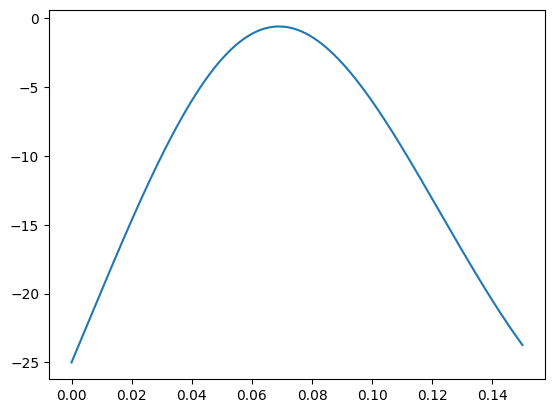

In [388]:
# dynamics equations
from matplotlib import pyplot as plt
# forward euler to plot some stuff
def euler(x0, dt, steps, dynamics_params):
    t = np.zeros(steps+1)
    x = np.zeros((len(x0),steps+1))
    x[:,0] = x0
    for i in range(1,steps+1):
        f = hsa_hopper.dynamics.evaluate(x[0,i-1],x[1,i-1],0,dynamics_params)
        x[0,i] = x[0,i-1] + dt*x[1,i-1] + (.5*dt**2)*f
        x[1,i] = x[1,i-1] + dt*f
        t[i] = t[i-1] + dt
    return x,t

x0 = np.array([theta1,thetadot1])
x,t = euler(x0,1e-4,int(1e4*tf),dynamics_params)
# plt.plot(t,np.array([y(_x) for _x in x[0,:]]))
# plt.plot(t,x[0,:])
# dy = np.array([forward_kinematics(kin_params,x[0,i],jacobian=True)[1][0] for i in range(t.shape[0])])
# plt.plot(t,dy)
plt.plot(t,x[0,:]*180/np.pi)

In [389]:
# import math
import hsa_hopper.collocation
collo_params = hsa_hopper.collocation.CollocationParameters(1,5,4,0,tf)
u = np.zeros(x.shape[1])
x_interp, u_interp = hsa_hopper.collocation.fit_interpolation(x[0,:],u,t,collo_params)

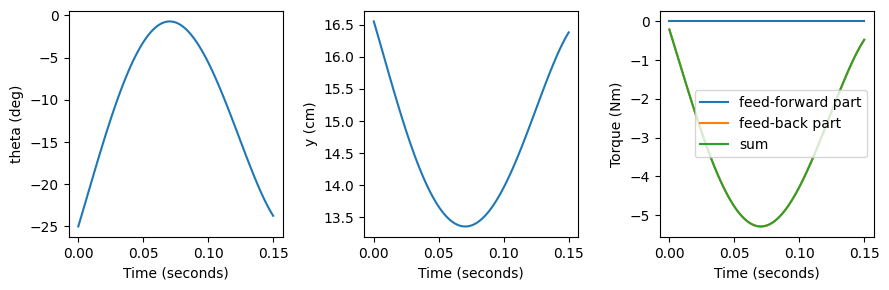

In [390]:
# visualise this interpolation
def make_interp_figure(x_interp, u_interp, dynamics_params):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(9,3))

    tk = x_interp.tk
    t_mat= np.vstack([np.linspace(tk[i], tk[i+1],100) for i in range(x_interp.M)])

    # compute interpolations
    x_data = np.hstack([[ x_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(x_interp.M)])
    y_data= y(x_data)
    u_data= np.hstack([[ u_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(u_interp.M)])
    t = t_mat.flatten()

    # make figures
    ax[0].plot(t, 180/np.pi*x_data)
    ax[1].plot(t, 100*y_data)
    ax[2].plot(t, u_data, label='feed-forward part')
    ax[2].plot(t, dynamics_params.Kx*(dynamics_params.x0-x_data), label='feed-back part')
    ax[2].plot(t, u_data+dynamics_params.Kx*(dynamics_params.x0-x_data), label='sum')

    ax[0].set_xlabel('Time (seconds)')
    ax[1].set_xlabel('Time (seconds)')
    ax[2].set_xlabel('Time (seconds)')

    ax[0].set_ylabel('theta (deg)')
    ax[1].set_ylabel('y (cm)')
    ax[2].set_ylabel('Torque (Nm)')
    ax[2].legend()
    fig.tight_layout()
    
make_interp_figure(x_interp,u_interp,dynamics_params)

# 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.0099778252269833
       x: [-1.138e-01  6.022e-02 -2.493e-01 -6.894e-02 -8.188e-02
            9.426e-01 -1.423e+00 -7.490e+00 -1.057e+00]
     nit: 4
     jac: [ 1.188e+01 -1.220e-01 -8.458e-01 -3.452e+00 -3.319e+00
           -9.899e-01 -4.454e-01 -4.487e-01 -2.635e-01]
    nfev: 4
    njev: 4


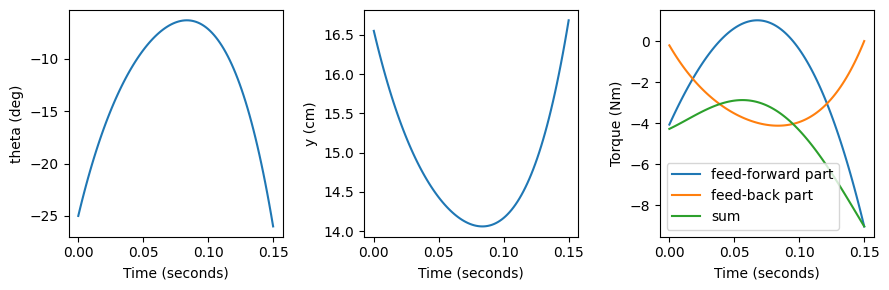

In [391]:
# import yaml
from scipy.optimize import minimize
# dynamics_params.psi = 10
z = np.hstack([x_interp.mat.flatten(),u_interp.mat.flatten()])
bvp = hsa_hopper.collocation.HopBVP(
    [theta1,thetadot1],
    [thetaN,thetadotN],
    [-50*np.pi/180,-20],
    [15*np.pi/180,20],
    dynamics_params,
    collo_params
)
result = bvp.optimize(z, options = {
    'ftol': 1e-3,
    'maxiter': 200,
    'eps': 1e-4,
},
regeneration=False)
print(result)

x_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.c_mat,collo_params.tk)
u_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.d_mat,collo_params.tk)
make_interp_figure(x_interp, u_interp,dynamics_params)

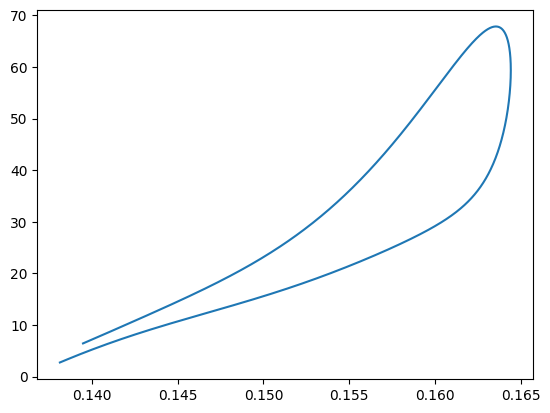

In [392]:
psi = dynamics_params.psi
t = np.linspace(0,tf,1000)
x = np.array([x_interp.evaluate(_t) for _t in t])
xdot = np.array([x_interp.evaluate(_t,ord=1) for _t in t])
l = np.array([forward_kinematics(kin_params,_x)[1] for _x in x])
dl = np.array([forward_kinematics(kin_params,_x,jacobian=True)[1][1] for _x in x])
u_ff = np.array([u_interp.evaluate(_t) for _t in t])
ldot = dl*xdot
hsa_force = np.array([potential.dV(l[i],psi,ldot[i]) for i in range(len(t))])
hsa_torque = np.array([-dl[i]*hsa_force[i] for i in range(len(l))])
# plt.plot(t,hsa_force)
# plt.plot(t,hsa_torque)
plt.plot(l,hsa_force)
# plt.plot(x,hsa_torque)
# plt.plot(t,dl)

In [393]:
# estimate how much power is dissipated in the HSA
work_in = np.trapz(hsa_force[:len(l)//2],x=l[:len(l)//2])
work_out = np.trapz(hsa_force[len(l)//2:],x=-l[len(l)//2:])
print(work_in)
print(work_out)
print((work_out)/work_in)

0.7849671727285049
0.4769768165832031
0.6076391894520335


In [394]:
# compute components of work,
# thermal work, negative mechancial work, positive mechanical work
torque = u_ff + dynamics_params.Kx*(dynamics_params.x0-x)
current = torque/.546
thermal_work = np.trapz(.094*current**2, x=t)
mech_power = torque*xdot
mech_work = np.trapz(mech_power,x=t)
pos_mech_work = np.trapz(np.clip(mech_power,0,np.inf),x=t)
neg_mech_work = pos_mech_work - mech_work
print(thermal_work)
print(pos_mech_work)
print(neg_mech_work)
print(mech_work)

1.070975895860855
2.42241430569005
1.1487716741513516
1.2736426315386984


In [395]:
stance_controller = {
    'u_interp': u_interp.attribute_dict(),
    'initial_conditions': [theta1,thetadot1],
    'final_conditions': [thetaN,thetadotN],
    'dynamics_params': dynamics_params.attribute_dict(),
    'x_td': theta_td,
    'x_lo': theta_lo,
    'xdot_td': thetadot1,
    'xdot_lo': thetadotN,
}
potential_string = ''
if dynamics_params.hsa_potential is None:
    potential_string = 'no_hsa'
    stance_controller['potential'] = None
else:
    potential_string = 'hsa'
    stance_controller['potential'] = dynamics_params.hsa_potential.attribute_dict()
    
with open(f'{potential_string}_stance_controller_{int(1000*dynamics_params.m)}g.yaml','w') as f:
    yaml.dump(stance_controller, f, yaml.Dumper)